In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [3]:
import pandas as pd
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
import deepmatcher as dm
import torch

In [4]:
attributes =['Beer_Name','Brew_Factory_Name','Style','ABV']

In [6]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/beer_hybrid.pth')
model = model.cuda()

In [7]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/Beer/'
                                                                         ,'negatives',128,model,
                                                                        model.classifier,device = 0)

In [8]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/Beer',
                                                                       'positives',64,model,
                                                                       model.classifier,device= 0)

In [9]:
classifier_len = len(neg_classifier_inputs[0][0])
attribute_len = int(classifier_len/len(attributes))

## Negative analysis

In [10]:
negatives_ri,neg_ri_norms = computeRi(model.classifier,attributes,neg_classifier_inputs,attribute_len,1)

100%|██████████| 126/126 [00:09<00:00, 13.47it/s]


In [11]:
negatives_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
negatives_variation_df.sum().plot.bar()

In [12]:
negatives_variation_df.to_csv('experiment-results/negatives_ri_hybrid.csv',index=False)

## Positive analysis

In [13]:
positives_ri,pos_ri_norms = computeRi(model.classifier,attributes,pos_classifier_inputs,attribute_len,0)

100%|██████████| 4/4 [00:00<00:00, 15.27it/s]


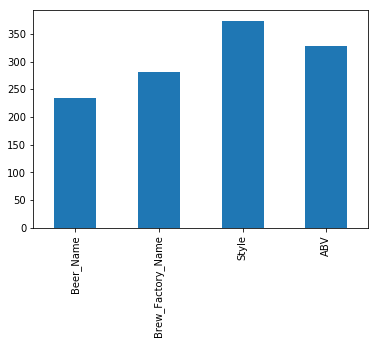

In [14]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum().plot.bar()

In [20]:
positives_variation_df.to_csv('experiment-results/positives_ri_hybrid.csv',index=False)

## Compute closer vectors

In [22]:
from utils.distance_measures import calculate_nearest_neighbors_onAttributes

In [15]:
train_df = pd.read_csv('../../Structured/Beer/merged_train.csv')
train_df[train_df.label==0].to_csv('../../Structured/Beer/train_negatives.csv',index=False)
train_df[train_df.label==1].to_csv('../../Structured/Beer/train_positives.csv',index=False)

In [16]:
train_neg,train_neg_ids = return_layer_input('../../Structured/Beer/','train_negatives',128,model,
                                                                        model.classifier,device = 0)

In [17]:
train_pos,train_pos_ids = return_layer_input('../../Structured/Beer/','train_positives',128,model,
                                                                        model.classifier,device = 0)

In [23]:
positives_nn = calculate_nearest_neighbors_onAttributes(pos_classifier_inputs,pos_ids,positives_ri,
                                                       train,neg_ids,attributes,attribute_len)

100%|██████████| 64/64 [00:00<00:00, 797.93it/s]


In [24]:
negatives_nn = calculate_nearest_neighbors_onAttributes(neg_classifier_inputs,neg_ids,negatives_ri,
                                                        pos_classifier_inputs,pos_ids,attributes,attribute_len)

100%|██████████| 128/128 [00:00<00:00, 966.06it/s]


In [25]:
positives_nn.to_csv('experiment-results/positives_nn_hybrid.csv',index=False)
negatives_nn.to_csv('experiment-results/negatives_nn_hybrid.csv',index=False)